# Removing bias enables generalization

In this notebook, we look at the generalization comparisions between a given model (e.g. DnCNN), and its bias free  version (e.g. BF_CNN). 

Inside the training range, the two models show comparable performance. However, outside the training range, bias free network, outperforms the other network signifincanly. 

In this notebook, we look at

1. comparative performance of the models on single images. 

2. comparative performance of the models averaged across many images. 




In [1]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.optim import Adam
import sys  
sys.path.insert(0, 'code')
from utils_train import *
from DnCNN import *
from BF_CNN import *

from skimage.measure.simple_metrics import compare_psnr, compare_mse


%matplotlib inline

### Load the data

In [67]:

train_folder_path = 'data/Train400/'
test_folder_path = 'data/Test/Set68/'
set12_path = 'data/Test/Set12/'

all_images= load_Berkley_dataset( train_folder_path, test_folder_path, set12_path)


### Load both trained models: 1) model with net bias, 2) model without net bias

In [129]:
all_params = {
'epochs': 50,
"learning_rate" : .001,
'parent_included': 'not applicable',
'kernel_size_waves': 'not applicable',

"kernel_size_mid" : 3,
"padding_mid" : 1,
"num_mid_kernels" : 64,
"num_mid_layers" : 20,

"batch_size" : 128,
"patch_size" : (50,50),
"patching_strides" : (10,10),
'scales' : [1,.9,.8,.7],
}

# select the noise range models have been trained on. 
l = 0  # lower bound of training range 
h = 10 # higher bound of training range

## model with bias: DnCNN
DnCNN = nn.DataParallel(dncnn(all_params))
DnCNN.load_state_dict(torch.load('models/DnCNN/range_'+str(l)+'_'+str(h)+'/model.pt',map_location='cpu' ))    
DnCNN.eval();


## model without bias: BF_CNN
BF_CNN = bf_cnn(all_params)
BF_CNN.load_state_dict(torch.load('models/BF_CNN/range_'+str(l)+'_'+str(h)+'/model.pt',map_location='cpu' ))    
running_sd = torch.load('models/BF_CNN/range_'+str(l)+'_'+str(h)+'/running_sd.pt', map_location='cpu')
for i in range(all_params['num_mid_layers']-2):
    BF_CNN.running_sd[i] = running_sd[i]    
BF_CNN.eval();




## 1. Comparing performance on a single image 

In [130]:
# Select the image you want to denoise from the test set
# choose noise level and image number 
noise_level = 90
image_num = 6

clean_im = all_images['set12'][image_num]
dim1, dim2 = clean_im.shape

noisy_im, noise = add_noise(clean_im.reshape(1,dim1,dim2), noise_level, 'S') 

inp_test = Variable(torch.FloatTensor(noisy_im).unsqueeze(1), volatile = True,requires_grad=False)

residual_dncnn= DnCNN(inp_test).data.squeeze(0).squeeze(0).numpy()
residual_bf_cnn= BF_CNN(inp_test).data.squeeze(0).squeeze(0).numpy()


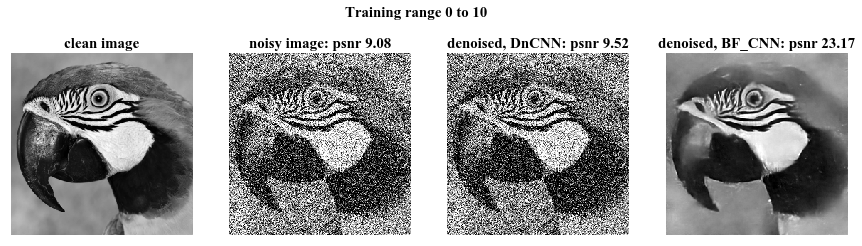

In [131]:
noisy_im = noisy_im.reshape(dim1,dim2)
denoised_dncnn = noisy_im - residual_dncnn.reshape(dim1,dim2)
denoised_bf_cnn = noisy_im - residual_bf_cnn.reshape(dim1,dim2)

f, axs = plt.subplots(1,4, figsize = (15,4), squeeze=True)

f.suptitle('Training range ' + str(l) +' to '+ str(h),  fontname= 'Times New Roman', fontsize = 15)

axs[0].imshow(clean_im, 'gray', vmin= 0, vmax = 1)
axs[0].set_title('clean image', fontname= 'Times New Roman', fontsize = 15)
axs[1].imshow(noisy_im, 'gray', vmin= 0, vmax = 1)
psnr = np.round(compare_psnr(clean_im, noisy_im),2)
axs[1].set_title('noisy image: psnr ' +str(psnr), fontname= 'Times New Roman', fontsize = 15)
axs[2].imshow(denoised_dncnn, 'gray', vmin= 0, vmax = 1)
psnr = np.round(compare_psnr(clean_im, denoised_dncnn),2)
axs[2].set_title('denoised, DnCNN: psnr ' +str(psnr), fontname= 'Times New Roman', fontsize = 15)
axs[3].imshow(denoised_bf_cnn, 'gray', vmin= 0, vmax = 1)
psnr = np.round(compare_psnr(clean_im, denoised_bf_cnn),2)
axs[3].set_title('denoised, BF_CNN: psnr ' +str(psnr), fontname= 'Times New Roman', fontsize = 15)
for i in range(4): 
    axs[i].set_xticks([], [])
    axs[i].set_yticks([], [])
    axs[i].axis('off')



## 2. Comparing performance across many images

In order to calculate PSNR on set 68 using another model, run psnr68_calculator.py. The results will be saved in the model's results folder. 

The following plot shows output PSNR against input PSNR for DnCNN vs. BFCNN.

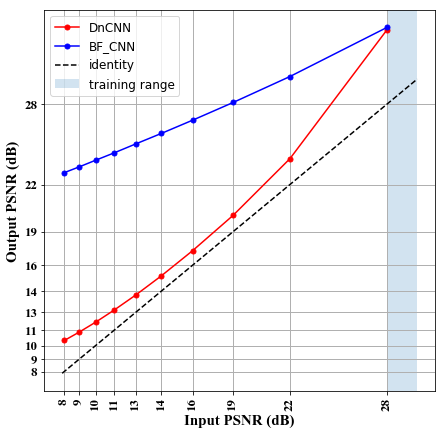

In [132]:
x_axis = [ -10*np.log10( (s/255)**2  ) for s in range(10,110,10)]

f , axs = plt.subplots(1,1, figsize=(7,7))

dncnn_psnr68 = np.load('models/DnCNN/range_'+str(l)+'_'+str(h)+'/results/psnr68_list.npy')
bf_cnn_psnr68 = np.load('models/BF_CNN/range_'+str(l)+'_'+str(h)+'/results/psnr68_list.npy')


axs.plot(x_axis, dncnn_psnr68[1::], color = 'red', marker = '.',markersize = 10, label = 'DnCNN')
axs.plot(x_axis, bf_cnn_psnr68[1::], color = 'blue', marker = '.',markersize = 10, label = 'BF_CNN')
axs.plot( [8,30],[8,30] ,'k--', alpha = 1, label = 'identity');

axs.set_xticks(x_axis)
axs.grid(  linewidth=1)
axs.set_yticks(x_axis)

axs.set_xticklabels(np.round(x_axis).astype(int) ,rotation=90, fontsize=13, fontname= 'Times New Roman')
axs.set_yticklabels(np.round(x_axis).astype(int) , fontsize=13, fontname= 'Times New Roman');
axs.set_xlabel('Input PSNR (dB)', fontsize=15, fontname= 'Times New Roman')
axs.set_ylabel('Output PSNR (dB)', fontsize=15, fontname= 'Times New Roman')

if l != 0:
    span_h = -10*np.log10( (l/255)**2)
else: 
    span_h = 30

span_l = -10*np.log10( (h/255)**2)

axs.axvspan(span_l , span_h  , alpha=0.2, label='training range');
axs.legend(fontsize = 12);

    



## 3. Network bias impairs generalization 

First-order analysis of the residual of a denoising convolutional neural network as a function of noise level. The plot shows the norms of the residual and the net bias averaged over 100 $20 \times 20$ natural-image patches for networks trained over different training ranges. The range of noises used for training is highlighted in blue. When the network is trained over the full range of noise levels the net bias is small, growing slightly as the noise increases.  When the network is trained over the a smaller range, the net bias grows explosively for noise levels beyond the training range. This coincides with a dramatic drop in performance, reflected in the difference between the magnitudes of the residual and the true noise. The CNN used for this example is DnCNN (Zhang et al., 2017); using alternative architectures yields similar results. 

In order to try this results on another network, run bias_linear_decomp.py module, available in code folder. The averaged values will be saved in the model's results folder. 

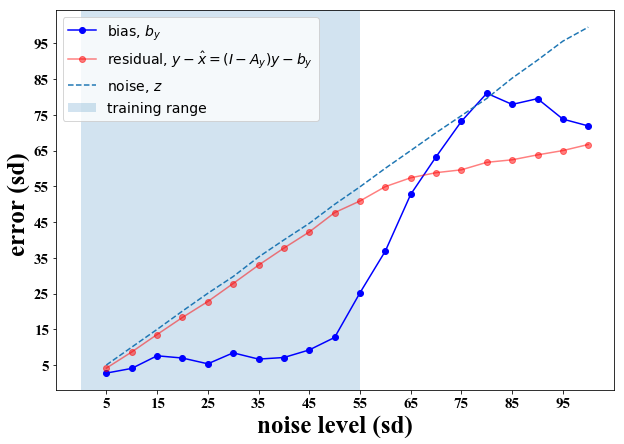

In [128]:
l = 0
h = 55

try:
    f, axs = plt.subplots(1,1, figsize = (10,7), sharey=True)
    plt.subplots_adjust()

    im_d = 20 

    folder_path = 'models/DnCNN/range_'+str(l)+'_'+str(h)+'/results'

    norm_b=np.load(folder_path  + '/norm_b_ave.npy'  )
    norm_res=np.load(folder_path  + '/norm_res_ave.npy'  )
    norm_noise=np.load(folder_path  + '/norm_noise_ave.npy'  )
    
    axs.plot( range(5,105,5),255* norm_b/20, 'b-o',label = r'bias, $b_y$', alpha = 1)
    axs.plot( range(5,105,5),255* norm_res/20, 'r-o',label = r'residual, $y-\hat{x}=(I-A_y)y-b_y$', alpha = .5)
    axs.plot( range(5,105,5),255* norm_noise/20, '--',label = r'noise, $z$', alpha = 1)


    axs.set_xticks(range(5,105,10))
    axs.set_yticks(range(5,105,10))

    axs.set_xlabel('noise level (sd)',fontsize=25, fontname= 'Times New Roman')
    axs.set_ylabel('error (sd) ',fontsize=25, fontname= 'Times New Roman')

    for tick in axs.get_xticklabels():
        tick.set_fontsize(15) 
        tick.set_fontname("Times New Roman")

    for tick in axs.get_yticklabels():
        tick.set_fontsize(15)
        tick.set_fontname("Times New Roman")

    axs.axvspan(l,h, alpha=0.2, label = 'training range');
    axs.legend(fontsize = 14);
except: 
    print('results not available for this model!')